# Solving the problem of water transport in dessicated soil

We start with a second-order BVP of the form

$$(K_rP)'=\frac{1}{2}x\Bigl(-\frac{dS}{dP}\Bigr)P'\\ 0<x<\infty$$
where

$$S=\frac{1-S_r}{1+(-P\frac{L}{A})^\eta}+S_r$$

$$K_r=\frac{1}{1+(-P\frac{L}{B})^\lambda}$$

$$P(0)=\beta_0, P(\infty)=\beta_1$$

$$S_r=0.31, A=231, B=146, \eta=3.65, \lambda=6.65, L=100$$

Analytically, we can rewrite this problem in a more standard form:

$$P''=\frac{1}{K_r}\biggl(\frac{1}{2}x\Bigl(-\frac{dS}{dP}\Bigr)P'-K_r'P'\biggr)$$

Additionally, the problem is defined in an infinite interval, so we simplify it by fixing the right-hand boundary at $b=10$ instead of $\infty$.

## Numerical solution using the shooting method

To solve the problem numerically, we first reduce it to a system of two first-order ODE by introducing $P_1=P$ and $P_2=P'$:

\begin{align}
dP_1&=P_2\\
dP_2&=\Bigl(1+\Bigl(-P_1\frac{L}{B}\Bigr)^\lambda\Bigr)\Biggl[\frac{1}{2}x\frac{-\eta\frac{L}{A}(1-S_r)(-P_1\frac{L}{A}^{\eta-1}P_1')}{\Bigl(1+(-P_1\frac{L}{A})^\eta\Bigr)^2}-\frac{(P_2')^2\lambda\frac{L}{B}(-P_1\frac{L}{B})^{\lambda-1}}{\Bigl(1+(-P_1\frac{L}{B})^\lambda\Bigr)^2}\Biggr]\\
P_1(0)&=\beta_0\\
P_2(0)&=dP(0)=s
\end{align}

By adjusting the free parameter $s$ and solving this initial value problem, we obtain different values in the right-hand boundary: $P_1(b; s)$

And so we define an error function $F: \mathbb{R}\rightarrow\mathbb{R}$ with

$$F(s)=P_1(b;s)-\beta_1$$

The problem is now reduced to finding the root $s_0$ of $F$ such that $F(s_0)=0$. Having determined the correct initial value for $P_2$, we can solve the initial value problem one last time to obtain the final solution. We will use a 4th-order Runge Kutta method to solve the given initial value problems numerically. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#This is the right-hand side of the IVP
def f(x,y,
     S_r=0.32,
     A=231,
     B=146,
     eta=3.65,
     l=6.65,
     L=100):
    P1=y[0]
    P2=y[1]
    dP1=P2
    
    T1=1+(-P1*L/B)**l
    T2=x/2
    T3=-eta*L/A*(1-S_r)*(-P1*L/A)**(eta-1)*P2
    T4=(1+(-P1*L/A)**eta)**2
    T5=-P2**2*l*L/B*(-P1*L/B)**(l-1)
    T6=(1+(-P1*L/B)**l)**2
    
    dP2=T1*(T2*T3/T4+T5/T6)

    return np.array([dP1, dP2])

#Fourth-order Runge-Kutta method for solving SDE
def rk4v(f, y0, x0, xn, n):
    d=y0.shape[0]
    y=np.zeros((d, n+1))
    y[:,0]=y0[:,0]
    h=(xn-x0)/n
    x=np.linspace(x0,xn,n+1)
    for i in range(n):
        k1=f(x[i], y[:,i])
        k2=f(x[i]+h/2, y[:,i]+h*k1/2)
        k3=f(x[i]+h/2, y[:,i]+h*k2/2)
        k4=f(x[i+1], y[:,i]+h*k3)

        y[:,i+1]=y[:,i]+h*(k1/6+k2/3+k3/3+k4/6)
    return y,x

#The error function
def F(s, yn):
    y0=np.array([[0], [s]])
    x0,xn=0,10
    n=100
    y_current,_=rk4v(f, y0, x0, xn, n)
    return y_current[0,-1]-yn


## Finding the root

As $F$ is a real-valued function in $\mathbb{R}$, finding its root is a relatively simple matter. In this instance, we have elected to use Newton's method. Since this method also needs to evaluate $dF$ in order to function, we will approximate the derivative using forward finite differentiation with $\delta s=10^{-5}$:

$$dF(s)\approx\frac{F(s+\delta s)-F(s)}{\delta s}$$

In [ ]:
#Newton's method for finding roots of real-valued function with a real variable
def Newton_approximate(F, s0, yn, accuracy, max_iter):
    delta=1e-5
    F_current=F(s0, yn)
    i=0
    while abs(F_current)>accuracy and i<max_iter:
        #slope approximation
        dF_current=(F(s0+delta, yn)-F_current)/delta
        s0=s0-F_current/dF_current
        F_current=F(s0, yn)
        #print(F_current, dF_current)
        i=i+1
    print('Newton method completed.')
    print('Final accuracy: ', F_current, '\nRoot: ', s0, '\nNewton iterations: ', i)
    return s0, i    

Before locating $s_0$ accurately, we can plot F(s) in a wide interval to confirm that it does, in fact, have a root. Even though this may not be possible in practice due to computational constraints, it will help us locate a good starting point for Newton's method. 

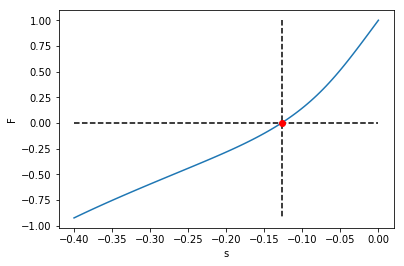

In [ ]:
s_vector=np.linspace(-0.4,0,100)
F_vector=[F(s, -1) for s in s_vector]
plt.plot(s_vector,F_vector)
plt.plot([s_vector[0], s_vector[-1]], [0, 0], 'k--')
plt.plot([-0.127, -0.127], [max(F_vector), min(F_vector)], 'k--')
plt.plot([-0.127], [0], 'ro')
plt.xlabel('s')
plt.ylabel('F')
plt.show()

We can now apply the shooting method to obtain an accurate value for $s_0$:

In [ ]:
S_r=0.32
A=231
B=146
eta=3.65
l=6.65
L=100

s0=-0.1
yn=-1
accuracy=1e-10
max_iter=30
s0,i=Newton_approximate(F, s0, yn, accuracy, max_iter)

Newton method completed.
Final accuracy:  8.427702979929563e-13 
Root:  -0.12738775152728626 
Newton iterations:  4


We have calculated $s_0$ to be $-0.127387$. Now we can plug that back into the IVP given above and use the Runge-Kutta method again to approximate the final solution for $P$:

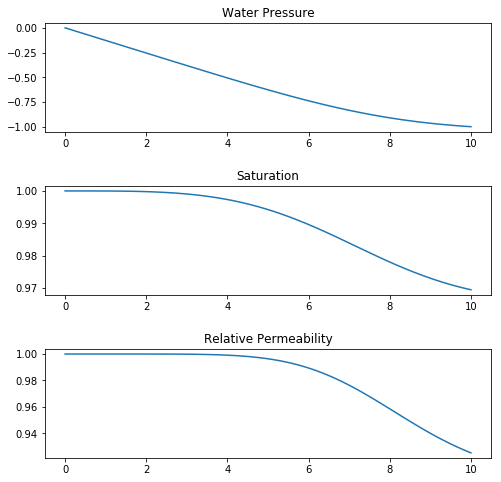

In [ ]:
x0,xn=0,10
n=100
y0=np.array([[0], [s0]])
y,x=rk4v(f, y0, x0, xn, n)
h=(xn-x0)/n

P=y[0,:]
dP=y[1,:]
S=(1-S_r)/(1+(-P*L/A)**eta) + S_r
K_r=1/(1+(-P*L/B)**l)

fig, (P_plot, S_plot, K_r_plot) = plt.subplots(3,1, figsize=(8,8))
P_plot.plot(x,P)
P_plot.set_title('Water Pressure', y=1)
S_plot.plot(x, S)
S_plot.set_title('Saturation', y=1)
K_r_plot.plot(x, K_r)
K_r_plot.set_title('Relative Permeability')
plt.subplots_adjust(hspace=0.5)

## Verifying the results

We don't have an exact solution for $P$, but we can still verify the accuracy of our approximation by observing whether it fits into the BVP from the start, using an error measure $e$ defined as the absolute difference between the left- and right-hand side of the initial problem, factoring in our approximations:

$$e_i=\mid(K_r'P)'(x_i)-\frac{1}{2}x_i\Bigl(-\frac{dS}{dP}(x_i)\Bigr)P'(x_i)\mid\\ 0<x<10$$

0.010053166423458156 0.022012488429503558 0.13241398216687947
-0.9999999999991572


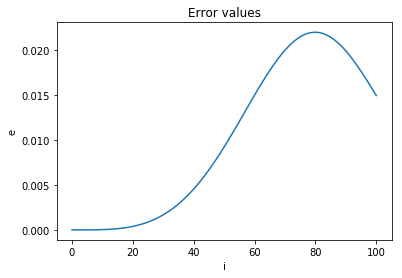

In [ ]:
e=abs((1+(-P*L/B)**l)*( (x/2*-eta*L/A*(1-S_r)*(-P*L/A)**(eta-1)*dP)/(1+(-P*L/A)**eta)**2
                      -dP**2*l*L/B*(-P*L/B)**(l-1)/(1+(-P*L/B)**l)**2 ))
print(np.average(e), max(abs(e)), np.linalg.norm(e))
plt.plot(e)
plt.xlabel('i')
plt.ylabel('e')
plt.title('Error values')
print(P[-1])

## Instability

One inconvenient property of the given problem is its instability - namely, the IVP can only be solved for a relatively narrow range of values $s$. Numerical methods diverge quickly for $s<-1$ and setting $s>0$ produces imaginary values immadiately, due to exponentiation of negative numbers in parts of the equation. We arrived at a suitable range of values where $F$ can actually be evaluated mostly by guess-work, which isn't exactly a rigorous mathematical principle. We believe this issue might be resolved computationally by searching through a wide range of values (e.g. $[-100,0]$), and seeing which values $F$ can be evaluated for, then starting the Newton search from there. 